# Assemble Garcia & Keeling 2001 O$_2$ flux product

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime

import numpy as np
import xarray as xr

from netCDF4 import default_fillvals

import matplotlib.pyplot as plt

import config
import fgo2_gk2001

### Generate datasets

### Shifting and scaling
The recommended Garcia and Keeling rescaling is 0.82 
(Naegler 2006 vs. Wanninkhof 1992 scaling factors 0.32/0.39), plus a 10-day shift later, to allow for mixed layer equilibration.

In [3]:
ds = fgo2_gk2001.open_flux_dataset(shift_time=10., scaleby=0.82, clobber=True)
ds

<xarray.Dataset>
Dimensions:       (lat: 160, lon: 320, time: 12)
Coordinates:
  * lat           (lat) float64 -89.44 -88.31 -87.19 ... 87.19 88.31 89.44
  * lon           (lon) float64 -179.4 -178.3 -177.2 ... 177.2 178.3 179.4
  * time          (time) float64 25.5 55.0 84.5 115.0 ... 298.5 329.0 359.5
Data variables:
    area          (lat, lon) float64 1.536e+08 1.536e+08 ... 1.536e+08 1.536e+08
    date          (time) float64 2e+07 2e+07 2e+07 2e+07 ... 2e+07 2e+07 2e+07
    fgo2_ann      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgo2_sea      (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgo2_thm_ann  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgo2_thm_sea  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgo2_bio_ann  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    fgo2_bio_sea  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

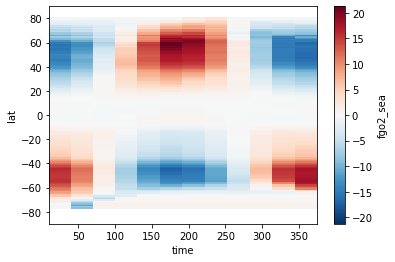

In [4]:
ds.fgo2_sea.mean("lon").T.plot()

Global sum Gruber: -0.1000 Tmol/yr
Global sum Resplandy: 0.8800 Tmol/yr


<xarray.DataArray 'fgo2' (lat: 160, lon: 320)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.95947659, 0.95947659, 0.95947659, ..., 0.95947659, 0.95947659,
        0.95947659],
       [0.95947659, 0.95947659, 0.95947659, ..., 0.95947659, 0.95947659,
        0.95947659],
       [0.95947659, 0.95947659, 0.95947659, ..., 0.95947659, 0.95947659,
        0.95947659]])
Coordinates:
  * lat      (lat) float64 -89.44 -88.31 -87.19 -86.06 ... 87.19 88.31 89.44
  * lon      (lon) float64 -179.4 -178.3 -177.2 -176.1 ... 177.2 178.3 179.4
Attributes:
    long_name:  Annual mean O2 flux (Resplandy et al. (2016))
    units:      mol/m^2/yr

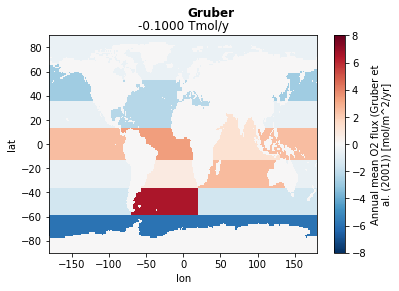

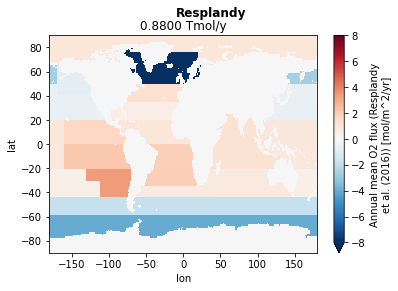

In [5]:
dsets_ann = {}
for product in ["Gruber", "Resplandy"]:
    fig = plt.figure()    
    ds_ann = fgo2_gk2001.open_inversion_annual_flux(product, gk_grid=True)
    ds_ann.fgo2.plot(vmin=-8., vmax=8., cmap='RdBu_r')
    dsets_ann[product] = ds_ann
    glb_sum = (ds_ann.fgo2 * ds_ann.area).sum() / 1e12
    plt.title(f"{glb_sum.values:0.4f} Tmol/y")
    fig.suptitle(product, fontweight="bold")    
ds_ann.fgo2  

### Make some quick plots of the fluxes

## Apply annual mean fluxes from Gruber et al. 2001 & Resplandy et al. 2016

In [6]:
dirout = config.flux_product_dir
clobber = True
dsets = {}
for product in ["Gruber", "Resplandy"]:

    dso = ds[["fgo2_sea", "fgo2_thm_sea", "fgo2_bio_sea", "area"]]    
    dso["fgo2"] = xr.full_like(ds.fgo2_sea, fill_value=0.)
    dso.fgo2.values = ds.fgo2_sea + dsets_ann[product].fgo2
    dso.fgo2.attrs["long_name"] = f"GK01 O$_2$ seasonal flux w/ {product} ann mean"
    dso.fgo2.encoding["_FillValue"] =  default_fillvals["f8"]

    for v in dso.data_vars:
        if "_FillValue" not in dso[v].encoding:
            dso[v].encoding["_FillValue"] = None

    dsets[product] = dso
    
    file_out = f"{dirout}/garcia-keeling.fgo2.{product.lower()}_ann.nc"    
    if clobber and os.path.exists(file_out):
        os.remove(file_out)
    if not os.path.exists(file_out):
        dso.to_netcdf(file_out)